In [1]:
import os
import csv
import copy
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from collections import defaultdict
import pandas as pd

from utils import *
import matplotlib.pyplot as plt
import numpy as np

# How well do zero-order optimization methods do for ML applications, compared to standard first-order methods?

First we define our training function on the MNIST dataset that will calculate different metrics such ass the train, test loss & accuracy, as well as the time elapsed for 1 epoch

In [14]:
def train(config, hybrid = False, model_h = None):
    '''
    Train and test the model
    Parameters
    ====================
    config: Dictionary
    {
        "model",
        "num_epochs",
        "batch_size_train",
        "batch_size_test",
        "optimizer": one of "zo_sgd", "zo_sign_sgd", "fo_sgd", "fo_sign_sgd",
        "learning_rate",
        "momentum": used when "optimizer"="fo_sgd",
        "dampening": used when "optimizer"="fo_sgd",
        "fd_eps": used when "optimizer"="zo_sgd" or "zo_sign_sgd",
        "use_true_grad": Boolean,
        "scheduler": Boolean,
        "decay_at_epochs": Iterable, used when scheduler=True,
        "decay_with_factor": used when scheduler=True
        ""
    }
    Return
    ====================
    best_acc: Best test accuracy
    '''
    
    # Set the seed for reproducibility
    torch.manual_seed(config["seed"])

    # We will run on CUDA if there is a GPU available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Configure the dataset, model and the optimizer based on the 'config' dictionary
    training_loader, test_loader = get_dataset(config)
    inputs, labels = next(iter(training_loader))
    inputs, labels = inputs.to(device), labels.to(device)
    
    #get model
    #print(device, config["model"])
    #print(type(device), type(config["model"]))
    model = get_model(device, config["model"], config["scale"])
    if (hybrid): model = model_h
    #Loss function
    # criterion = torch.nn.BCELoss() # [TODO] maybe use CrossEntropyLoss
    criterion = torch.nn.CrossEntropyLoss()
    
    #get optimizer
    optimizer, scheduler = get_optimizer(model.parameters(), config,
                                         model, inputs, labels, criterion)

    # Store the loss and accuracy
    epoch_metrics = defaultdict(list)
    
    for epoch in range(config["num_epochs"]):
        print("Epoch {}/{}".format(epoch, config["num_epochs"]))
        start = time.time()
        batch_metrics = defaultdict(float)

        # Training mode
        model.train()
        
        for batch_idx, (inputs, labels) in enumerate(training_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            #print(batch_idx)
            # Compute gradients for the batch
            optimizer.zero_grad()
            prediction = model(inputs)
            loss = criterion(prediction, labels)
            acc = accuracy(prediction, labels)
            loss.backward()

            # Do an optimizer step
            optimizer.step()

            # Store the statistics
            batch_metrics["train_loss"] += loss.detach().cpu().numpy()
            batch_metrics["train_acc"] += acc.detach().cpu().numpy()

        # Update the optimizer's learning rate
        if scheduler:
            scheduler.step()

        # Log training stats
        epoch_loss = batch_metrics["train_loss"] / (batch_idx + 1)
        epoch_acc = batch_metrics["train_acc"] / (batch_idx + 1)
        #sepoch_metrics["train_loss"].append(batch_metrics["train_loss"])
        epoch_metrics["train_loss"].append(epoch_loss)
        epoch_metrics["train_acc"].append(epoch_acc)
        print("train loss: {:.3f}, train accuracy: {:.3f}".format(epoch_loss, epoch_acc))
        
        #epoch time
        end = time.time()
        elapsed = end - start
        epoch_metrics["time"].append(elapsed)
    
    return epoch_metrics, model

def visualize_results(names, metrics):
    
    fig, ax = plt.subplots(2, 1, figsize = (6, 6))
    
    for idx, metric in enumerate(metrics):
        for jdx, m in enumerate(metric):
            
            if (jdx == 2): continue
            axrow = 0
            if (m.split("_")[1] == "acc"): axrow = 1
            
            ax[axrow].plot(metric[m], label = names[idx])
            ax[axrow].set_title(m)
            ax[axrow].legend()
    plt.show()
    
def visualize_time(names, metrics): 
    plt.figure(figsize = (10, 6))
    colors = ["red", "royalblue", "yellow", "green", "salmon", "purple", "peru", "teal"]
    for idx, metric in enumerate(metrics): 
        plt.hist(metric["time"],bins=10, 
                 alpha=0.4, label=names[idx], color=colors[idx],density=False)
    plt.xlabel('Training Time per Epoch (s)')
    plt.ylabel('Epochs')
    plt.title('Frequency of Training Time per Epoch')
    plt.legend()
    plt.show()

## ZO_SGD vs FO_SGD

In [3]:
#now we define different configurations

config_zo = {
    "seed": 42,
    "model": "mynet",
    "num_epochs": 20,
    "batch_size_train": 64,
    "batch_size_test": 1000,
    "optimizer": "zo_sgd",
    "learning_rate": 1e-2,
    "momentum": 0,
    "dampening": 0,
    "fd_eps": 1e-3,
    "use_true_grad": False,
    "scheduler": False,
    "decay_at_epochs": [50],
    "decay_with_factor": 10,
    "scale": 1
}
config_fo = {
    "seed": 42,
    "model": "mynet",
    "num_epochs": 20,
    "batch_size_train": 64,
    "batch_size_test": 1000,
    "optimizer": "fo_sgd",
    "learning_rate": 1e-2,
    "momentum": 0.9,
    "dampening": 0,
    "fd_eps": 1e-2,
    "use_true_grad": False,
    "scheduler": False,
    "decay_at_epochs": [50],
    "decay_with_factor": 10,
    "scale": 1
}

In [4]:
zo_metrics = train(config_zo)

Epoch 0/20


/Users/louis/Desktop/jup/ZOsimplify/project/models.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.a(x)


train loss: 2.244, train accuracy: 0.211
Epoch 1/20
train loss: 2.068, train accuracy: 0.414
Epoch 2/20
train loss: 1.986, train accuracy: 0.510
Epoch 3/20
train loss: 1.928, train accuracy: 0.568
Epoch 4/20
train loss: 1.910, train accuracy: 0.585
Epoch 5/20
train loss: 1.889, train accuracy: 0.600
Epoch 6/20
train loss: 1.880, train accuracy: 0.605
Epoch 7/20
train loss: 1.876, train accuracy: 0.607
Epoch 8/20
train loss: 1.872, train accuracy: 0.608
Epoch 9/20
train loss: 1.871, train accuracy: 0.609
Epoch 10/20
train loss: 1.869, train accuracy: 0.610
Epoch 11/20
train loss: 1.868, train accuracy: 0.610
Epoch 12/20
train loss: 1.866, train accuracy: 0.611
Epoch 13/20
train loss: 1.865, train accuracy: 0.611
Epoch 14/20
train loss: 1.864, train accuracy: 0.612
Epoch 15/20
train loss: 1.864, train accuracy: 0.612
Epoch 16/20
train loss: 1.863, train accuracy: 0.612
Epoch 17/20
train loss: 1.863, train accuracy: 0.612
Epoch 18/20
train loss: 1.862, train accuracy: 0.612
Epoch 19/20
tr

In [5]:
fo_metrics = train(config_fo)

Epoch 0/20
train loss: 1.753, train accuracy: 0.747
Epoch 1/20
train loss: 1.547, train accuracy: 0.921
Epoch 2/20
train loss: 1.528, train accuracy: 0.939
Epoch 3/20
train loss: 1.517, train accuracy: 0.949
Epoch 4/20
train loss: 1.509, train accuracy: 0.956
Epoch 5/20
train loss: 1.502, train accuracy: 0.963
Epoch 6/20
train loss: 1.498, train accuracy: 0.967
Epoch 7/20
train loss: 1.494, train accuracy: 0.970
Epoch 8/20
train loss: 1.491, train accuracy: 0.973
Epoch 9/20
train loss: 1.488, train accuracy: 0.975
Epoch 10/20
train loss: 1.486, train accuracy: 0.978
Epoch 11/20
train loss: 1.484, train accuracy: 0.979
Epoch 12/20
train loss: 1.482, train accuracy: 0.981
Epoch 13/20
train loss: 1.481, train accuracy: 0.982
Epoch 14/20
train loss: 1.480, train accuracy: 0.983
Epoch 15/20
train loss: 1.478, train accuracy: 0.985
Epoch 16/20
train loss: 1.477, train accuracy: 0.986
Epoch 17/20
train loss: 1.476, train accuracy: 0.986
Epoch 18/20
train loss: 1.475, train accuracy: 0.987
Epo

In [10]:
pd.DataFrame(zo_metrics[0]).to_csv("results/ZO_SGD.csv")
pd.DataFrame(fo_metrics[0]).to_csv("results/FO_SGD.csv")

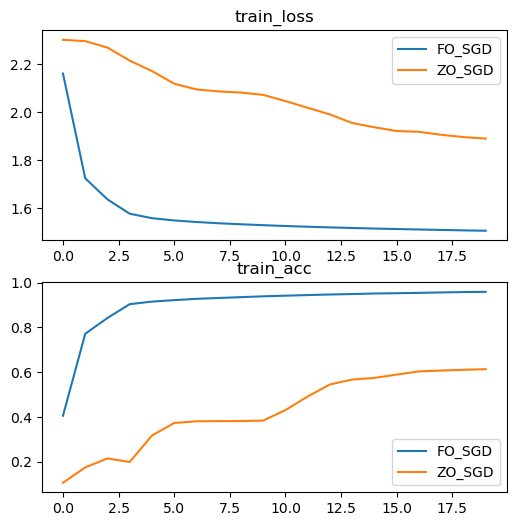

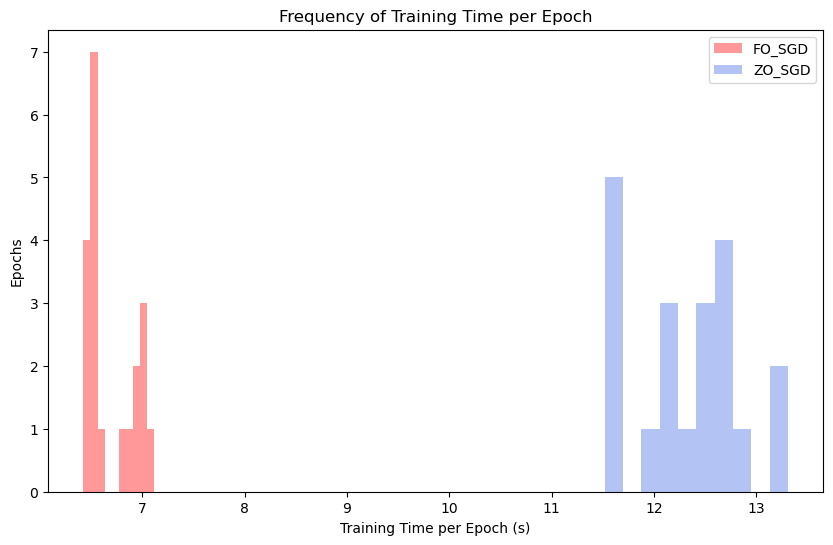

In [26]:
visualize_results(["FO_SGD", "ZO_SGD"], [fo_metrics[0], zo_metrics[0]])
visualize_time(["FO_SGD", "ZO_SGD"], [fo_metrics[0], zo_metrics[0]])

## Convolutional Network

In [9]:
config_zo["model"] = "conv"
config_zo["num_epochs"]= 3
config_fo["model"] = "conv"
config_fo["num_epochs"]= 5
#zo_metrics = train(config_zo)
fo_metrics = train(config_fo)

Epoch 0/5
train loss: 0.151, train accuracy: 0.954
Epoch 1/5
train loss: 0.053, train accuracy: 0.983
Epoch 2/5
train loss: 0.040, train accuracy: 0.988
Epoch 3/5
train loss: 0.032, train accuracy: 0.990
Epoch 4/5
train loss: 0.026, train accuracy: 0.992


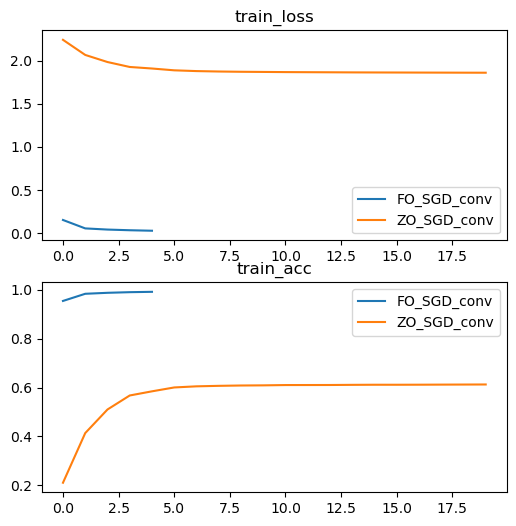

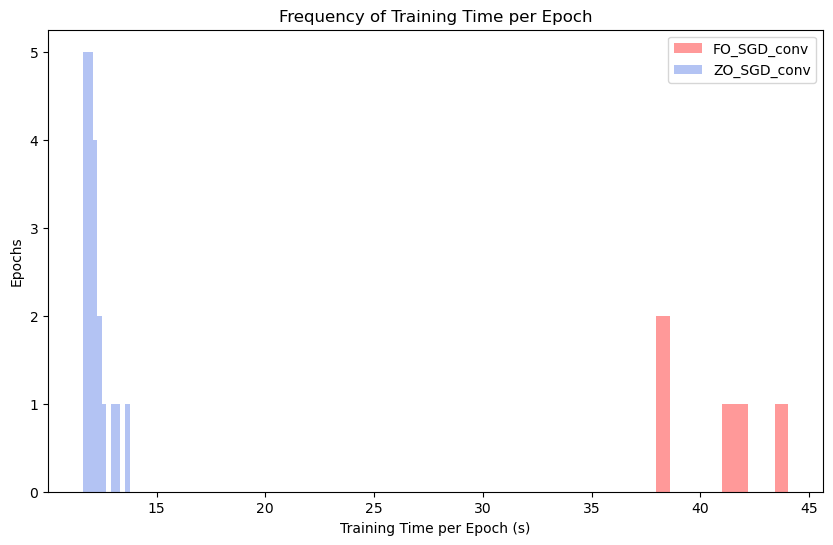

In [11]:
pd.DataFrame(zo_metrics[0]).to_csv("results/ZO_SGD_conv.csv")
pd.DataFrame(fo_metrics[0]).to_csv("results/FO_SGD_conv.csv")
visualize_results(["FO_SGD_conv", "ZO_SGD_conv"], [fo_metrics[0], zo_metrics[0]])
visualize_time(["FO_SGD_conv", "ZO_SGD_conv"], [fo_metrics[0], zo_metrics[0]])

## Scale change

Epoch 0/10
train loss: 2.260, train accuracy: 0.175
Epoch 1/10
train loss: 2.160, train accuracy: 0.299
Epoch 2/10
train loss: 2.071, train accuracy: 0.405
Epoch 3/10
train loss: 2.052, train accuracy: 0.414
Epoch 4/10
train loss: 2.027, train accuracy: 0.452
Epoch 5/10
train loss: 1.988, train accuracy: 0.496
Epoch 6/10
train loss: 1.973, train accuracy: 0.502
Epoch 7/10
train loss: 1.966, train accuracy: 0.507
Epoch 8/10
train loss: 1.962, train accuracy: 0.509
Epoch 9/10
train loss: 1.965, train accuracy: 0.503
Epoch 0/10
train loss: 1.810, train accuracy: 0.676
Epoch 1/10
train loss: 1.632, train accuracy: 0.833
Epoch 2/10
train loss: 1.618, train accuracy: 0.846
Epoch 3/10
train loss: 1.608, train accuracy: 0.854
Epoch 4/10
train loss: 1.602, train accuracy: 0.861
Epoch 5/10
train loss: 1.597, train accuracy: 0.866
Epoch 6/10
train loss: 1.593, train accuracy: 0.869
Epoch 7/10
train loss: 1.591, train accuracy: 0.871
Epoch 8/10
train loss: 1.588, train accuracy: 0.873
Epoch 9/10
t

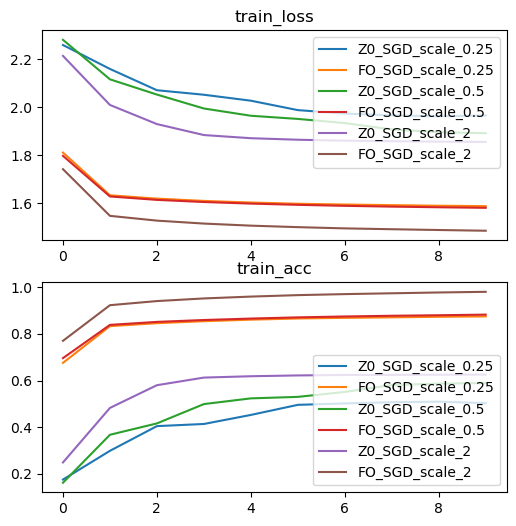

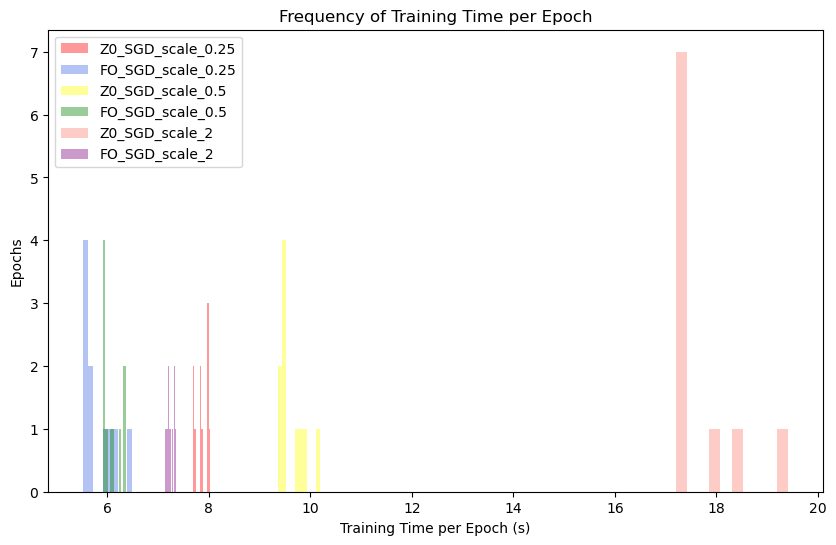

In [15]:
config_zo["model"] = "mynet"
config_fo["model"] = "mynet"
config_zo["num_epochs"]= 10
config_fo["num_epochs"]= 10
scales = [0.25, 0.5, 2]
metric_list = []
name_list = []
for s in scales: 
    config_zo["scale"] = s
    config_fo["scale"] = s
    zo_metrics = train(config_zo)
    fo_metrics = train(config_fo)
    metric_list.append(zo_metrics[0])
    metric_list.append(fo_metrics[0])
    zo_name = f"Z0_SGD_scale_{str(s)}"
    fo_name = f"FO_SGD_scale_{str(s)}"
    name_list.append(f"Z0_SGD_scale_{str(s)}")
    name_list.append(f"FO_SGD_scale_{str(s)}")
    pd.DataFrame(zo_metrics[0]).to_csv(f"results/{zo_name}.csv")
    pd.DataFrame(fo_metrics[0]).to_csv(f"results/{fo_name}.csv")
    

visualize_results(name_list, metric_list)
visualize_time(name_list, metric_list)

## Hybrid optimization

In [35]:
def combine_metrics(m1, m2):
    for m in m1: 
        for element in m2[m]:
            m1[m].append(element)
    return m1

In [37]:
#combine_metrics(zo_metrics[0], fo_metrics[0])

In [39]:
n_epochs = 10
splits = [(.25, .75), (.5, .5), (.75, .25)]
metrics = []
names = []

for s in splits:
    #ZO then FO
    config_zo["num_epochs"] = int(s[0]*n_epochs)
    config_fo["num_epochs"] = int(s[1]*n_epochs)
    h1_metrics, h1_model = train(config_zo) #h1 -> hybrid step 1
    h2_metrics, _ = train(config_fo, hybrid=True, model_h=h1_model)
    name = f"ZOFO_SGD_split_{s[0]}"
    m = combine_metrics(h1_metrics, h2_metrics)
    pd.DataFrame(m).to_csv(f"results/{name}.csv")
    metrics.append(m)
    names.append(name)
    #FO then ZO
    config_fo["num_epochs"] = int(s[0]*n_epochs)
    config_zo["num_epochs"] = int(s[1]*n_epochs)
    h1_metrics, h1_model = train(config_fo) #h1 -> hybrid step 1
    h2_metrics, _ = train(config_zo, hybrid=True, model_h=h1_model)
    name = f"FOZO_SGD_split_{s[0]}"
    m = combine_metrics(h1_metrics, h2_metrics)
    pd.DataFrame(m).to_csv(f"results/{name}.csv")
    metrics.append(m)
    names.append(name)

Epoch 0/2
train loss: 2.214, train accuracy: 0.249
Epoch 1/2
train loss: 2.009, train accuracy: 0.483
Epoch 0/7
train loss: 1.690, train accuracy: 0.780
Epoch 1/7
train loss: 1.615, train accuracy: 0.850
Epoch 2/7
train loss: 1.603, train accuracy: 0.861
Epoch 3/7
train loss: 1.595, train accuracy: 0.868
Epoch 4/7
train loss: 1.582, train accuracy: 0.881
Epoch 5/7
train loss: 1.504, train accuracy: 0.961
Epoch 6/7
train loss: 1.495, train accuracy: 0.970
Epoch 0/2
train loss: 1.741, train accuracy: 0.770
Epoch 1/2
train loss: 1.546, train accuracy: 0.923
Epoch 0/7
train loss: 1.547, train accuracy: 0.921
Epoch 1/7
train loss: 1.552, train accuracy: 0.915
Epoch 2/7
train loss: 1.552, train accuracy: 0.916
Epoch 3/7
train loss: 1.552, train accuracy: 0.916
Epoch 4/7
train loss: 1.552, train accuracy: 0.916
Epoch 5/7
train loss: 1.552, train accuracy: 0.916
Epoch 6/7
train loss: 1.552, train accuracy: 0.916
Epoch 0/5
train loss: 2.214, train accuracy: 0.249
Epoch 1/5
train loss: 2.009, tr

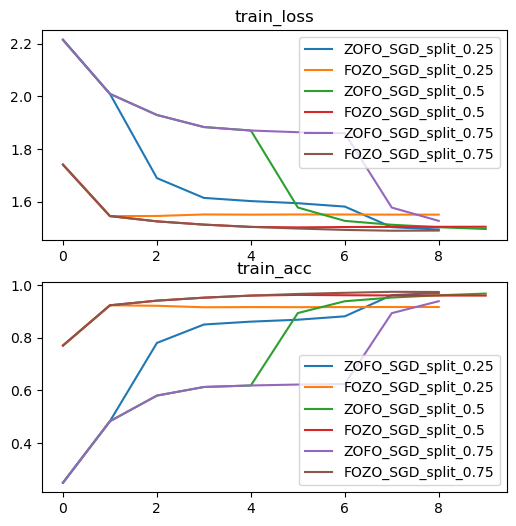

In [40]:
visualize_results(names, metrics)
#visualize_time(names, metrics)

In [4]:
#scalability how bad does zero model decrease
#is there a mix of optimizers that out performs one
#when large datasets are in use